In [51]:
import zipfile, io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

from joblib import dump, load

In [4]:
zippedFile = "archive.zip"

In [6]:
with zipfile.ZipFile(zippedFile, "r") as z_f:
    allfiles = z_f.extractall()

z_f.namelist()

['adult.csv']

In [4]:
csv = "income.csv"

In [6]:
df = pd.read_csv(csv)
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [8]:
pd.set_option("display.max_columns", None)

Some of these columns have `?` as values.
- So One Hot Encoding adds a prefix to the `?` to specify the column it belongs
- One hot encoding is to convert all the unique values of a feature(column) to binary form meaning: all the unique values are converted to individual columns and assigned `1` in the row they exist and `0` in the rows they don't exist

In [5]:
df.occupation.value_counts()

occupation
Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
?                    2809
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: count, dtype: int64

Redundant column

In [10]:
colsToDrop = ["education", "fnlwgt"]
df = df.drop(columns=colsToDrop)


Check for least important features

One Hot encode manually to get correlation

In [12]:
df = pd.concat([df.drop("workclass", axis=1), pd.get_dummies(df.workclass).add_prefix("workclass_")], axis=1)
df = pd.concat([df.drop("marital-status", axis=1), pd.get_dummies(df["marital-status"]).add_prefix("marital-status_")], axis=1)
df = pd.concat([df.drop("relationship", axis=1), pd.get_dummies(df.relationship).add_prefix("relationship_")], axis=1)
df = pd.concat([df.drop("race", axis=1), pd.get_dummies(df.race).add_prefix("race_")], axis=1)
df = pd.concat([df.drop("native-country", axis=1), pd.get_dummies(df["native-country"]).add_prefix("native-country_")], axis=1)
df = pd.concat([df.drop("occupation", axis=1), pd.get_dummies(df.occupation).add_prefix("occupation_")], axis=1)

In [14]:
df["gender"] = df["gender"].map({
    "Male": 1,
    "Female":  0
}).astype(int)
df.head()
df["income"] = df["income"].apply(lambda x: 1 if x == ">50K" else 0)

In [16]:
df.income.value_counts()

income
0    37155
1    11687
Name: count, dtype: int64

In [18]:
corr_matrix = df.corr()
income_corr = corr_matrix["income"].drop("income")
# income_corr = income_corr.reindex(income_corr.abs().sort_values().index)

# Get top 20 strongest correlations (absolute value, sorted)
top20_features = income_corr.abs().sort_values().tail(20).index

# Create a smaller dataframe containing only these top 20 + income
top_corr_matrix = df[top20_features.tolist() + ["income"]].corr()
top_corr_matrix

,occupation_Adm-clerical,race_Black,relationship_Wife,marital-status_Divorced,workclass_Self-emp-inc,relationship_Unmarried,capital-loss,occupation_Other-service,occupation_Prof-specialty,relationship_Not-in-family,occupation_Exec-managerial,gender,capital-gain,relationship_Own-child,hours-per-week,age,marital-status_Never-married,educational-num,relationship_Husband,marital-status_Married-civ-spouse,income
occupation_Adm-clerical,1.000000,0.043559,0.076564,0.080590,-0.051822,0.101243,-0.021457,-0.120618,-0.137017,0.041763,-0.135922,-0.260349,-0.029105,0.048423,-0.078916,-0.038116,0.069432,0.004142,-0.174442,-0.138648,-0.086475
race_Black,0.043559,1.000000,0.000785,0.014765,-0.047326,0.148007,-0.020956,0.081239,-0.046250,0.002547,-0.049002,-0.111481,-0.021456,0.021469,-0.047961,-0.017324,0.071866,-0.074364,-0.124728,-0.123302,-0.090448
relationship_Wife,0.076564,0.000785,1.000000,-0.088745,-0.006766,-0.076651,0.015849,0.011181,0.050421,-0.131880,0.015861,-0.317284,0.017416,-0.095959,-0.066714,0.023430,-0.157107,0.035749,-0.184188,0.239007,0.120484
marital-status_Divorced,0.080590,0.014765,-0.088745,1.000000,-0.027491,0.326257,-0.019524,0.018547,-0.007769,0.262269,0.011489,-0.228775,-0.015182,-0.094825,0.022173,0.130563,-0.278198,-0.003881,-0.326153,-0.364547,-0.128335
workclass_Self-emp-inc,-0.051822,-0.047326,-0.006766,-0.027491,1.000000,-0.036449,0.037036,-0.047875,0.010372,-0.046983,0.137443,0.083388,0.103144,-0.052544,0.124680,0.098962,-0.082866,0.079783,0.115089,0.109420,0.139596
relationship_Unmarried,0.101243,0.148007,-0.076651,0.326257,-0.036449,1.000000,-0.034718,0.069997,-0.018826,-0.201700,-0.023385,-0.316325,-0.028864,-0.146763,-0.034536,0.041670,-0.050888,-0.059461,-0.281703,-0.314864,-0.143642
capital-loss,-0.021457,-0.020956,0.015849,-0.019524,0.037036,-0.034718,1.000000,-0.038029,0.045043,-0.015585,0.049699,0.045480,-0.031441,-0.049167,0.054467,0.056944,-0.058121,0.080972,0.070839,0.075570,0.147554
occupation_Other-service,-0.120618,0.081239,0.011181,0.018547,-0.047875,0.069997,-0.038029,1.000000,-0.127333,0.030589,-0.126315,-0.153990,-0.038725,0.101582,-0.153209,-0.086321,0.118238,-0.168937,-0.168451,-0.159381,-0.155254
occupation_Prof-specialty,-0.137017,-0.046250,0.050421,-0.007769,0.010372,-0.018826,0.045043,-0.127333,1.000000,0.044797,-0.143489,-0.025639,0.085070,-0.083211,0.057104,0.053155,-0.024592,0.417956,0.025314,0.043786,0.188793
relationship_Not-in-family,0.041763,0.002547,-0.131880,0.262269,-0.046983,-0.201700,-0.015585,0.030589,0.044797,1.000000,-0.000555,-0.168916,-0.023329,-0.252509,0.005109,-0.009538,0.294898,0.057004,-0.484678,-0.539571,-0.190372


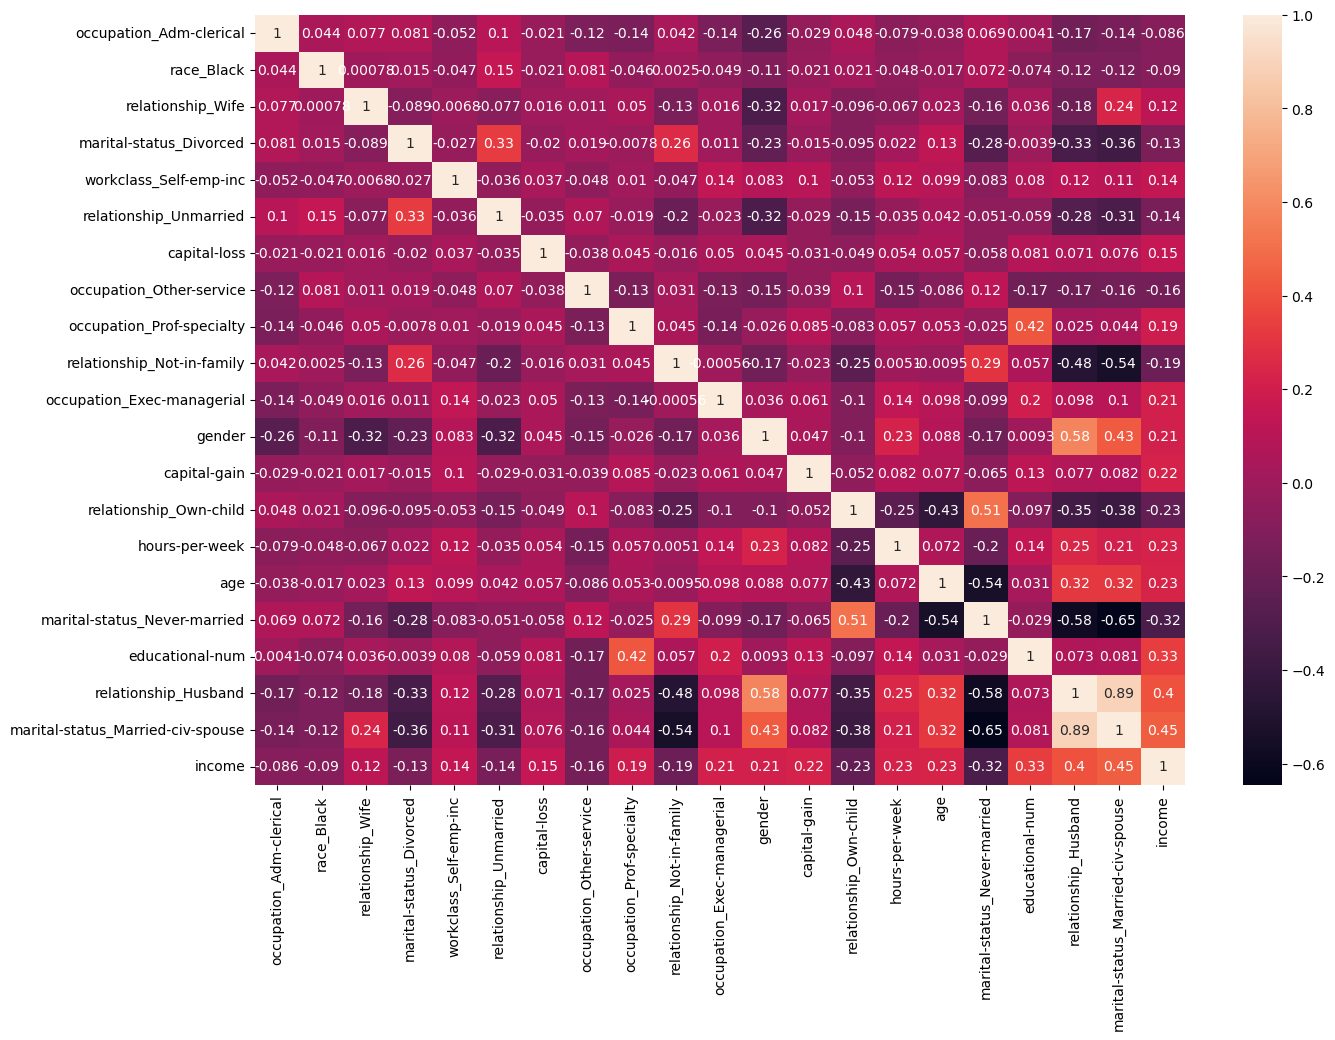

In [20]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(top_corr_matrix, annot=True);

In [22]:
target = "income"
X = df.drop(columns=target, axis=1)
y = df[target]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Try SMOTE for resmapling inbalanced classes

In [105]:
smote = SMOTE(sampling_strategy=0.7, random_state= 42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [107]:
clf = RandomForestClassifier(random_state=42, class_weight="balanced")

In [109]:
clf.fit(X_train_res, y_train_res)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [37]:
baseline = df.income.value_counts(normalize=True).max()
baseline

0.7607182343065395

In [111]:
clf.score(X_test, y_test)

0.8480908997850343

Check for most important features

In [182]:
importances = clf.feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp


native-country_Holand-Netherlands            0.000001
workclass_Never-worked                       0.000003
native-country_Honduras                      0.000020
native-country_Outlying-US(Guam-USVI-etc)    0.000049
occupation_Armed-Forces                      0.000086
                                               ...   
marital-status_Married-civ-spouse            0.066899
capital-gain                                 0.110559
hours-per-week                               0.114855
educational-num                              0.126349
age                                          0.230487
Length: 90, dtype: float64

In [113]:
params = {
    "n_estimators": [200, 250, 300, 400],
    "max_depth": [25, 30, 35, None],
    "min_samples_split": [6, 8, 10],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True, False]
}

In [115]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = RandomizedSearchCV(
    estimator=clf,
    param_distributions=params,
    n_iter=25,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [117]:
model.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [25, 30, 35, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [6, 8, 10],
                                        'n_estimators': [200, 250, 300, 400]},
                   random_state=42, scoring='f1', verbose=1)

In [120]:
print(model.best_params_)

{'n_estimators': 250, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


In [40]:
best_model = model.best_estimator_
importances = best_model.feature_importances_
features = best_model.feature_names_in_
feat_imp = pd.Series(importances, index=features).sort_values()
print(feat_imp.tail(15))

occupation_Other-service             0.013033
relationship_Wife                    0.013588
gender                               0.016453
occupation_Prof-specialty            0.017170
occupation_Exec-managerial           0.017406
relationship_Not-in-family           0.018511
relationship_Own-child               0.019760
capital-loss                         0.027596
marital-status_Never-married         0.047140
relationship_Husband                 0.071431
capital-gain                         0.082049
marital-status_Married-civ-spouse    0.092995
hours-per-week                       0.097413
educational-num                      0.120070
age                                  0.195814
dtype: float64


In [122]:
score = model.score(X_test, y_test)
score

0.7155390914408267

In [152]:
dump(model, "income_predictor.joblib")

['income_predictor.joblib']

In [124]:
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[6475 1004]
 [ 455 1835]]
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      7479
           1       0.65      0.80      0.72      2290

    accuracy                           0.85      9769
   macro avg       0.79      0.83      0.81      9769
weighted avg       0.87      0.85      0.86      9769



In [130]:
y_proba = model.predict_proba(X_test)[:, 1]
for threshold in [0.5, 0.55, 0.6]:
    y_pred = (y_proba > threshold).astype(int)
    print(f"Threshold: {threshold}")
    print(classification_report(y_test, y_pred))

Threshold: 0.5
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      7479
           1       0.65      0.80      0.72      2290

    accuracy                           0.85      9769
   macro avg       0.79      0.83      0.81      9769
weighted avg       0.87      0.85      0.86      9769

Threshold: 0.55
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      7479
           1       0.67      0.76      0.72      2290

    accuracy                           0.86      9769
   macro avg       0.80      0.83      0.81      9769
weighted avg       0.87      0.86      0.86      9769

Threshold: 0.6
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      7479
           1       0.70      0.73      0.71      2290

    accuracy                           0.86      9769
   macro avg       0.81      0.82      0.81      9769
weighted avg       0.86     

In [4]:
from income_prediction import wrangle, predict_income

In [6]:
df = wrangle("income.csv")

In [8]:
results = predict_income(df)

23.93% of people make more than 50k of the dataset while 76.07% of people earn below 50k
Fitting 5 folds for each of 48 candidates, totalling 240 fits
The model's best parametres are: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__n_estimators': 250}
The model's train score with cross validation is 0.9556727151741612
The model's test score with cross validation is 0.8530044016787798
The most important features are: cat__occupation_Prof-specialty            0.010609
cat__relationship_Unmarried               0.011732
cat__relationship_Wife                    0.012348
cat__occupation_Other-service             0.012761
cat__occupation_Exec-managerial           0.016544
cat__relationship_Not-in-family           0.019207
cat__relationship_Own-child               0.023002
num__capital-loss                         0.029018
cat__marital-status_Never-married         0.045795
cat_